### CONDA ENVIRONMENTS

For steps __1. preprocess__ and __2. mip__, `conda activate g5ht-pipeline`

For step __3. segment__, `conda activate segment-torch` or `conda activate torchcu129`

For step __4. spline, 5. orient, 6. warp, 7. reg__

## TODO:

1. I wonder if I computed a spline on each and every z slice and warped each, oriented each of them, and warped each of them, if the problem of weirdly sheared image stacks would be solved
2. quick mp4 for all recordings
   1. now working in engaging, works per one nd2 sbatch
3. focus check for all recordings
   1. maybe focus check can be used to specify which z slices are good to use and which frames are good to use
4. for recordings starting in december 2025, need to trim first 2 rather than last 2 z slices
5. flip worms so that VNC is always up
6. fixed mask could be automated, but if not, make sure to save which index is fixed
7. extract behavior
8. posture similarity
   1. posture might consist of the spline + thresholded z-stack
      1. I'm thinking that the orientation shouldn't matter, but the z-planes in focus will, and curvature/spline of the head will
      2. maybe need to actually interpolate to 117 z slices
   2. sub registration problems
   3. label each set of registered frames with one set of ROIs, or auto segment ROIs from each set of registered frames
9.  track z over time, which zslices are consistent
   1. focus + correlation
10. beads -> train/test
11. gfp+1 relative to rfp channel (might only apply to pre december 2025 recordings)
12. wholistic 
    1.  parameter sweep, might change
    2.  python version
13. autocorr/scorr
14. automate z slice trimming
    1.  pre december 2025 (trim last 2 z slices)
    2.  post december 2025 (trim first z slice)
15. photobleaching estimation?
    1.  record immo with serotonin
    2.  at least do it for RFP
16. try deltaF/F [ (F(t) - F0) / F0 ]
17. coding directions (preencounter-baseline) (postencounter-baseline)
    1.  then show voxel weights
18. port everything to engaging

In [1]:
import sys
import os
import importlib
from tqdm import tqdm

try:
    import utils
    is_torch_env = False
except ImportError:
    is_torch_env = True
    print("utils not loaded because conda environment doesn't have nd2reader installed. probably using torchcu129 env, which is totally fine for just doing the segmentation step")

## SPECIFY DATA TO PROCESS

In [2]:
# DATA_PTH = r'C:\Users\munib\POSTDOC\DATA\fluorescent_beads_ch_align\20251219'
DATA_PTH = r'D:\DATA\g5ht-free\20260123'

INPUT_ND2 = 'date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005.nd2'

INPUT_ND2_PTH = os.path.join(DATA_PTH, INPUT_ND2)

NOISE_PTH = r'C:\Users\munib\POSTDOC\CODE\g5ht-pipeline\noise\noise_042925.tif'

OUT_DIR = os.path.splitext(INPUT_ND2_PTH)[0]

STACK_LENGTH = 41

if not is_torch_env:
    noise_stack = utils.get_noise_stack(NOISE_PTH, STACK_LENGTH)
    num_frames, height, width, num_channels = utils.get_range_from_nd2(INPUT_ND2_PTH, stack_length=STACK_LENGTH) 
    beads_alignment_file = utils.get_beads_alignment_file(INPUT_ND2_PTH)
else:
    print("utils not loaded because conda environment doesn't have nd2reader installed. probably using torchcu129 env, which is totally fine for just doing the segmentation step")

print(INPUT_ND2)
print('Num z-slices: ', STACK_LENGTH)
if not is_torch_env:
    print('Number of frames: ', num_frames)
    print('Height: ', height)
    print('width: ', width)
    print('Number of channels: ', num_channels)
    print('Beads alignment file: ', beads_alignment_file)

date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005.nd2
Num z-slices:  41
Number of frames:  715
Height:  512
width:  512
Number of channels:  2
Beads alignment file:  D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005_chan_alignment.nd2


## 0. PROCESS BEADS ALIGNMENT DATA (OPTIONAL, CHANGING THIS SO BEADS ARE PROCESSED SEAMLESSLY IN PIPELINE)

` conda activate g5ht-pipeline`

The registration parameters between green and red channels will be applied to worm recordings

### SHEAR CORRECT AND CHANNEL REGISTER

In [ ]:
from preprocess_parallel import main as preprocess_nd2_parallel
_ = importlib.reload(sys.modules['preprocess_parallel'])

num_frames_beads, _, _, _ = utils.get_range_from_nd2(beads_alignment_file, stack_length=STACK_LENGTH) 

# # command-line arguments
sys.argv = ["", beads_alignment_file, "0", str(num_frames_beads-1), NOISE_PTH, STACK_LENGTH, 5, num_frames_beads, height, width, num_channels]

# # Call the main function
preprocess_nd2_parallel()

### MIP

This step saved the median channel registration parameters, need to do this somewhere else

In [ ]:
from mip import main as mip

_ = importlib.reload(sys.modules['mip'])
_ = importlib.reload(sys.modules['utils'])

# command-line arguments
sys.argv = ["", beads_alignment_file, STACK_LENGTH, num_frames_beads, 2]

# Call the main function
mip()

## 1. SHEAR CORRECTION

` conda activate g5ht-pipeline`

- shear corrects each volume
  - depending on each exposure time, it can take roughly half a second between the first and last frames of a volume, so any movements need to be corrected for
- creates one `.tif` for each volume and stores it in the `shear_corrected` directory

##### TODO: should probably update stack length after shear correction since we cut it by 2, although not sure it's explicitly needed

In [3]:
import shear_correct
_ = importlib.reload(sys.modules['shear_correct'])

start_index = "0"
end_index = str(num_frames-1)
# start_index = "800"
# end_index = "803"
# cpu_count = str(int(os.cpu_count() / 2))
cpu_count = str(int(os.cpu_count()))

# sys.argv = ["", nd2 file, start_frame, end_frame, noise_pth, stack_length, n_workers, num_frames, height, width, num_channels]
sys.argv = ["", INPUT_ND2_PTH, start_index, end_index, NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels]

# Call the main function
shear_correct.main()

Processing 715 stacks (0-714) using 24 workers...


100%|██████████| 715/715 [1:07:10<00:00,  5.64s/it]


Parallel preprocessing complete.


## 2. CHANNEL ALIGNMENT

` conda activate g5ht-pipeline`

### 2a. GET MEDIAN CHANNEL ALIGNMENT PARAMETERS FROM ALL FRAMES

- If channel alignment file found, uses that, if not uses worm recording
- creates a `.txt` file for each volume that contains elastix channel registration parameters
- creates `chan_align_params.csv` and  `chan_align.txt`

In [4]:
beads_alignment_file

'D:\\DATA\\g5ht-free\\20260123\\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005_chan_alignment.nd2'

In [5]:
import get_channel_alignment
import median_channel_alignment
_ = importlib.reload(sys.modules['get_channel_alignment'])
_ = importlib.reload(sys.modules['median_channel_alignment'])

## set beads_alignment_file to None to use worm recording for channel alignment, even if beads file exists
# beads_alignment_file = None

start_index = "0"
# cpu_count = str(int(os.cpu_count() / 2))
cpu_count = str(int(os.cpu_count()))

if beads_alignment_file is not None:
    align_with_beads = True
    num_frames_beads, _, _, _ = utils.get_range_from_nd2(beads_alignment_file, stack_length=STACK_LENGTH) 
    sys.argv = ["", beads_alignment_file, start_index, str(num_frames_beads-1), NOISE_PTH, STACK_LENGTH, cpu_count, num_frames_beads, height, width, num_channels, align_with_beads]
else:
    align_with_beads = False
    sys.argv = ["", INPUT_ND2_PTH, start_index, str(num_frames-1), NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels, align_with_beads]

# # Call the main function
get_channel_alignment.main()
median_channel_alignment.main()


Processing 50 stacks (0-49) using 24 workers...


100%|██████████| 50/50 [02:25<00:00,  2.92s/it] 


Parallel preprocessing complete.


### 2b. APPLY MEDIAN CHANNEL ALIGNMENT PARAMETERS

- ouputs aligned volumes in `channel_aligned` directory

In [6]:
import apply_channel_alignment
_ = importlib.reload(sys.modules['apply_channel_alignment'])

start_index = "0"
# cpu_count = str(int(os.cpu_count() / 2))
cpu_count = str(int(os.cpu_count()))

# 0786 to 0799 are bad frames in worm005.nd2, copied 0785 for each of those frames

if beads_alignment_file is not None:
    align_with_beads = True
    num_frames_beads, _, _, _ = utils.get_range_from_nd2(beads_alignment_file, stack_length=STACK_LENGTH) 
    sys.argv = ["", INPUT_ND2_PTH, start_index, str(num_frames-1), NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels, align_with_beads, beads_alignment_file]
else:
    align_with_beads = False
    sys.argv = ["", INPUT_ND2_PTH, start_index, str(num_frames-1), NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels, align_with_beads]


# Call the main function
apply_channel_alignment.main()

Processing 715 stacks (0-714) using 24 workers...


100%|██████████| 715/715 [08:03<00:00,  1.48it/s]

Parallel preprocessing complete.


In [ ]:
# # create copies of 0785 and rename it to 0786 to 0799
# import shutil
# for i in range(786, 800):
#     shutil.copyfile(r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005\channel_aligned\0785.tif',
#                     r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005\channel_aligned\{:04d}.tif'.format(i))

### 2c. PLOT CHANNEL ALIGNMENT PARAMETER DISTRIBUTIONS

In [8]:
out_dir

'D:\\DATA\\g5ht-free\\20260123\\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005'

No chan_align_params.csv found for worm recording


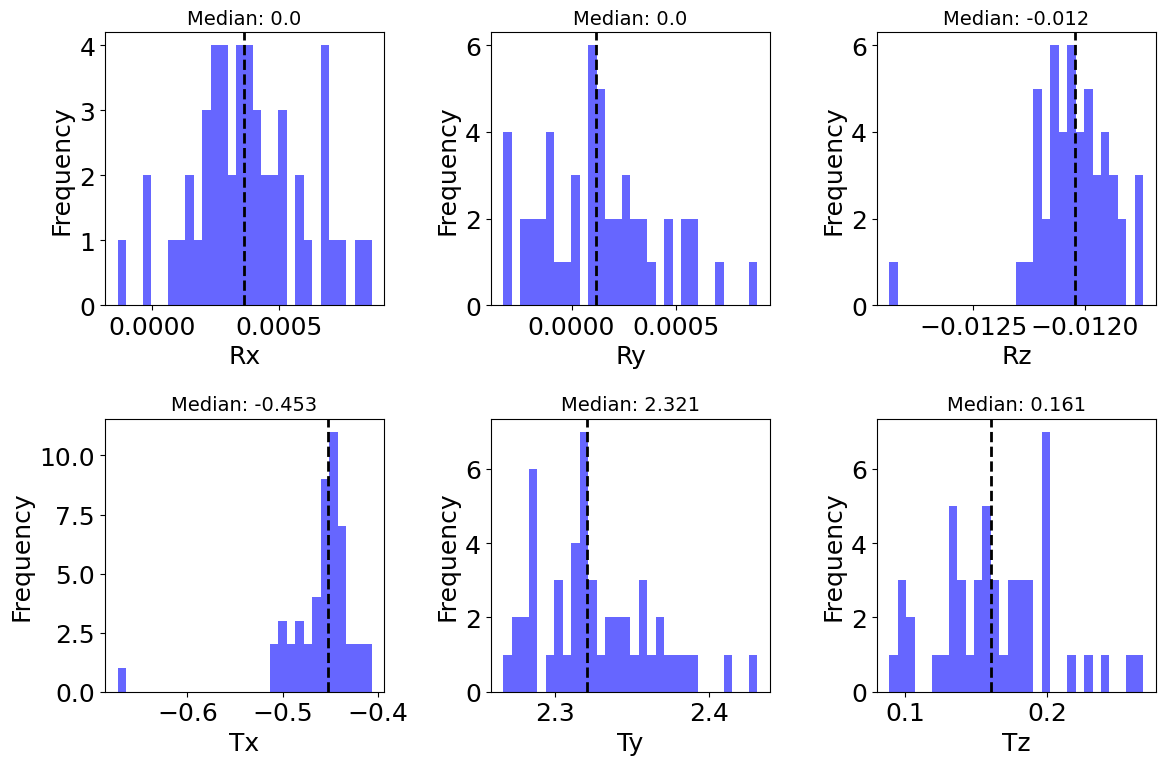

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# make font sizes larger for visibility
plt.rcParams.update({'font.size': 18})

try:
    out_dir = os.path.splitext(INPUT_ND2_PTH)[0]

    df = pd.read_csv(os.path.join(out_dir, 'chan_align_params.csv'))
    params = ['TransformParameter_0', 'TransformParameter_1', 'TransformParameter_2', 'TransformParameter_3', 'TransformParameter_4', 'TransformParameter_5']
    labels = ['Rx', 'Ry', 'Rz', 'Tx', 'Ty', 'Tz']

    # the xaxis limits for each subplot should be the same across figures

    xlims = np.zeros((6,2))

    plt.figure(figsize=(12,8), tight_layout=True)
    for i,param in enumerate(params):
        plt.subplot(2, 3, i+1)
        plt.hist(df[param], bins=30, color='red', alpha=0.6)
        # plot the median value as a vertical line
        median_value = df[param].median()
        plt.axvline(median_value, color='black', linestyle='dashed', linewidth=2)
        plt.xlabel(labels[i])
        plt.ylabel('Frequency')
        # get xaxis limits
        xlims[i,:] = plt.xlim()
        # title is median value
        plt.title(f'Median: {np.round(median_value,3)}', fontsize=14)
    plt.show()
except FileNotFoundError:
    print("No chan_align_params.csv found for worm recording")

out_dir = os.path.splitext(INPUT_ND2_PTH)[0] + '_chan_alignment'
df = pd.read_csv(os.path.join(out_dir, 'chan_align_params.csv'))
params = ['TransformParameter_0', 'TransformParameter_1', 'TransformParameter_2', 'TransformParameter_3', 'TransformParameter_4', 'TransformParameter_5']
labels = ['Rx', 'Ry', 'Rz', 'Tx', 'Ty', 'Tz']

plt.figure(figsize=(12,8), tight_layout=True)
for i,param in enumerate(params):
    plt.subplot(2, 3, i+1)
    plt.hist(df[param], bins=30, color='blue', alpha=0.6)
    # plot the median value as a vertical line
    median_value = df[param].median()
    plt.axvline(median_value, color='black', linestyle='dashed', linewidth=2)
    plt.xlabel(labels[i])
    plt.ylabel('Frequency')
    # apply xlims
    # plt.xlim(xlims[i,0], xlims[i,1])
    # title is median value, font size 14
    plt.title(f'Median: {np.round(median_value,3)}', fontsize=14)
plt.show()

## 3. BLEACH CORRECTION

TODO:
- per z slice?



In [11]:
import importlib
import os
import sys

import bleach_correct
_ = importlib.reload(sys.modules['bleach_correct'])


PTH = os.path.splitext(INPUT_ND2_PTH)[0]
REG_DIR = 'channel_aligned' # 'channel_aligned' or 'tif' 
channels = 1
method = 'block' # 'block' or 'exponential'
mode = 'total' # 'total' or 'median'

bleach_correct.correct_bleaching(os.path.join(PTH,REG_DIR), channels=channels, method=method, fbc=0.04, intensity_mode=mode)


# # Correct RFP only with block method (default)
# correct_bleaching("path/to/data")

# # Correct both channels with exponential fit
# correct_bleaching("path/to/data", channels=[0, 1], method='exponential')

# # Command line
# python bleach_correct.py path/to/data --channels 0 1 --method exponential

Found 715 volumes in D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005\channel_aligned
Channels to correct: ['RFP']
Method: block
Intensity mode: total

Processing RFP channel (index 1)
  Calculating total RFP signal...
Calculating RFP total signal: volume 715/715
  Divided into 25 blocks
  Computing block mean signals...
    Block 1/25: volumes 0-154, mean signal = 2.76e+08
    Block 2/25: volumes 155-208, mean signal = 2.74e+08
    Block 3/25: volumes 209-258, mean signal = 2.71e+08
    Block 4/25: volumes 259-285, mean signal = 2.68e+08
    Block 5/25: volumes 286-309, mean signal = 2.67e+08
    Block 6/25: volumes 310-333, mean signal = 2.64e+08
    Block 7/25: volumes 334-347, mean signal = 2.62e+08
    Block 8/25: volumes 348-366, mean signal = 2.59e+08
    Block 9/25: volumes 367-378, mean signal = 2.57e+08
    Block 10/25: volumes 379-394, mean signal = 2.54e+08
    Block 11/25: volumes 395-415, mean signal = 2.52e+08
    Block 12/25: vol

## 4. MIP

` conda activate g5ht-pipeline`

- outputs `means.png`, `focus.png`, `mip.tif`, and `mip.mp4`, `focus_check.csv`

##### TODO: 
- legend for focus.png, should be frame#
- mip for xy, xz, zy
- mip for several slices

Checking focus... 

100%|██████████| 715/715 [00:16<00:00, 42.66it/s]
<tifffile.TiffWriter 'mip_bleach_corre…d_RFP_block.tif'> writing nonconformant BigTIFF ImageJ


0000.tif written to mip_bleach_corrected_RFP_block.tif
0001.tif written to mip_bleach_corrected_RFP_block.tif
0002.tif written to mip_bleach_corrected_RFP_block.tif
0003.tif written to mip_bleach_corrected_RFP_block.tif
0004.tif written to mip_bleach_corrected_RFP_block.tif
0005.tif written to mip_bleach_corrected_RFP_block.tif
0006.tif written to mip_bleach_corrected_RFP_block.tif
0007.tif written to mip_bleach_corrected_RFP_block.tif
0008.tif written to mip_bleach_corrected_RFP_block.tif
0009.tif written to mip_bleach_corrected_RFP_block.tif
0010.tif written to mip_bleach_corrected_RFP_block.tif
0011.tif written to mip_bleach_corrected_RFP_block.tif
0012.tif written to mip_bleach_corrected_RFP_block.tif
0013.tif written to mip_bleach_corrected_RFP_block.tif
0014.tif written to mip_bleach_corrected_RFP_block.tif
0015.tif written to mip_bleach_corrected_RFP_block.tif
0016.tif written to mip_bleach_corrected_RFP_block.tif
0017.tif written to mip_bleach_corrected_RFP_block.tif
0018.tif w

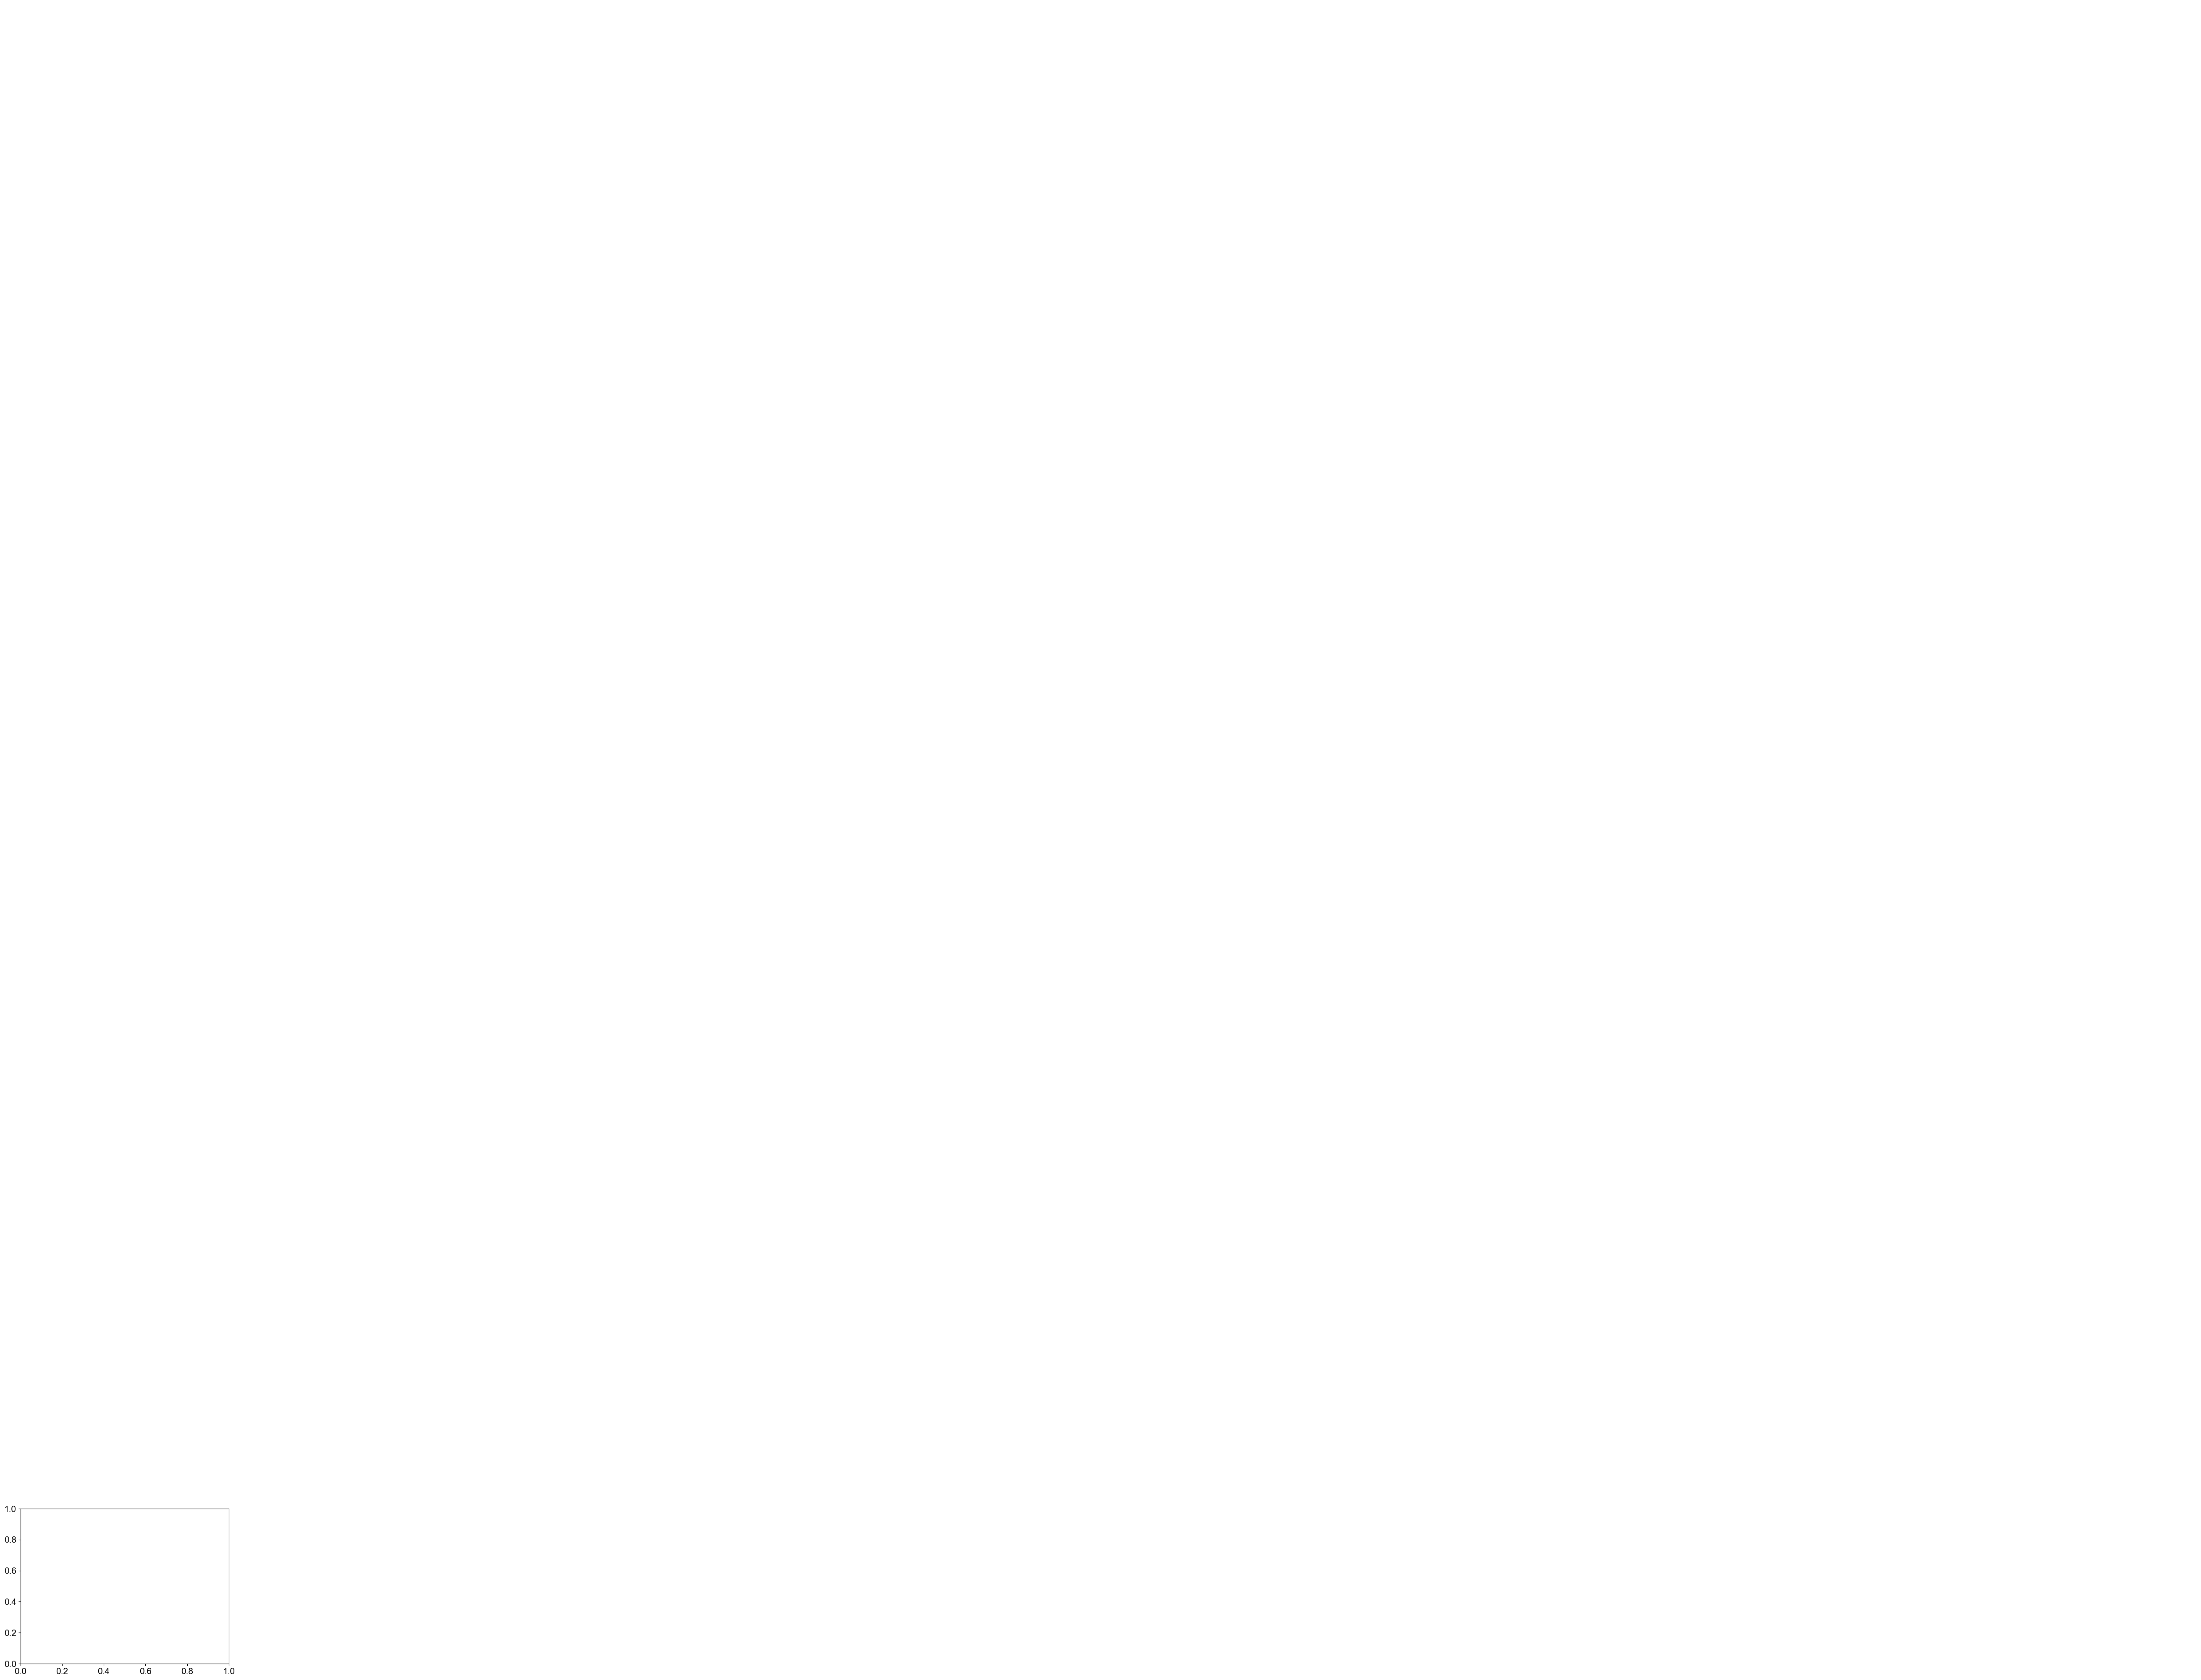

In [16]:
import mip

_ = importlib.reload(sys.modules['mip'])
_ = importlib.reload(sys.modules['utils'])

# command-line arguments
framerate = 6
tif_dir = 'bleach_corrected_RFP_block' # one of 'shear_corrected' 'channel_aligned' 'bleach_corrected_RFP_block'
# tif_dir = 'channel_aligned_beads'
rmax = 850
gmax = 150
mp4_quality = 10
sys.argv = ["", INPUT_ND2_PTH, tif_dir, STACK_LENGTH, num_frames, framerate, rmax, gmax, mp4_quality]

# Call the main function
mip.main()

## 5 DRIFT ESTIMATION

` conda activate g5ht-pipeline`

- outputs  `z_selection.csv`, `z_selection_diagnostics.png`, `sharpness.csv`

TODO:
- use z selection going forward
- also use sharpness/focus (and other things) to determine good/bad frames

In [ ]:
import drift_estimation

_ = importlib.reload(sys.modules['drift_estimation'])
_ = importlib.reload(sys.modules['utils'])

# command-line arguments
tif_dir = 'bleach_corrected_RFP_block' # one of 'shear_corrected' 'channel_aligned' 'bleach_corrected_RFP_block'

sys.argv = ["", INPUT_ND2_PTH, tif_dir, STACK_LENGTH, num_frames]

# Call the main function
drift_estimation.main()

Computing sharpness-based focus metrics...


Computing sharpness: 100%|██████████| 715/715 [02:41<00:00,  4.43it/s]



Z-slice selection complete:
  Total frames: 715
  Z-slices per frame: 24
  Frames needing padding: 641 (89.7%)
  Total drift: 25.92 z-slices
  Max drift from start: 26.02 z-slices


## 5. SEGMENT

- outputs `label.tif`, contains segmented MIP for each volume

__on home pc__: 
`conda activate segment-torch`

Uses a separate conda environment from the rest of the pipeline. create it using:
`conda env create -f segment_torch.yml`

__on lab pc__: 
`conda activate torchcu129`

Uses a separate conda environment from the rest of the pipeline. create it following steps in:
`segment_torch_cu129_environment.yml`

### setup each time model weights change
Need to set path to model weights as `CHECKPOINT` in `eval_torch.py`

In [4]:
import segment.segment_torch
_ = importlib.reload(sys.modules['segment.segment_torch'])

MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'mip_bleach_corrected_RFP_block.tif')

# command-line arguments
sys.argv = ["", MIP_PTH]

segment.segment_torch.main()

mip_bleach_corrected_RFP_block: 0
mip_bleach_corrected_RFP_block: 4
mip_bleach_corrected_RFP_block: 8
mip_bleach_corrected_RFP_block: 12
mip_bleach_corrected_RFP_block: 16
mip_bleach_corrected_RFP_block: 20
mip_bleach_corrected_RFP_block: 24
mip_bleach_corrected_RFP_block: 28
mip_bleach_corrected_RFP_block: 32
mip_bleach_corrected_RFP_block: 36
mip_bleach_corrected_RFP_block: 40
mip_bleach_corrected_RFP_block: 44
mip_bleach_corrected_RFP_block: 48
mip_bleach_corrected_RFP_block: 52
mip_bleach_corrected_RFP_block: 56
mip_bleach_corrected_RFP_block: 60
mip_bleach_corrected_RFP_block: 64
mip_bleach_corrected_RFP_block: 68
mip_bleach_corrected_RFP_block: 72
mip_bleach_corrected_RFP_block: 76
mip_bleach_corrected_RFP_block: 80
mip_bleach_corrected_RFP_block: 84
mip_bleach_corrected_RFP_block: 88
mip_bleach_corrected_RFP_block: 92
mip_bleach_corrected_RFP_block: 96
mip_bleach_corrected_RFP_block: 100
mip_bleach_corrected_RFP_block: 104
mip_bleach_corrected_RFP_block: 108
mip_bleach_corrected

## 6. SPLINE

`conda activate g5ht-pipeline`

- outputs `spline.json`, `spline.tif`, and `dilated.tif`

In [3]:
import spline
_ = importlib.reload(sys.modules['spline'])

LABEL_PTH = MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'label.tif')

# command-line arguments
sys.argv = ["", LABEL_PTH]

spline.main()

100%|██████████| 715/715 [00:42<00:00, 16.63it/s]


## 7. ORIENT

`conda activate g5ht-pipeline`

- outputs `oriented.json`, `oriented.png`, `oriented_stack.tif`

NOTE: `orient_v2.py` automated the process of finding orientation completely, whereas `orient.py` requires you to input the (x,y) nose location on the first frame

100%|██████████| 715/715 [00:01<00:00, 477.01it/s]


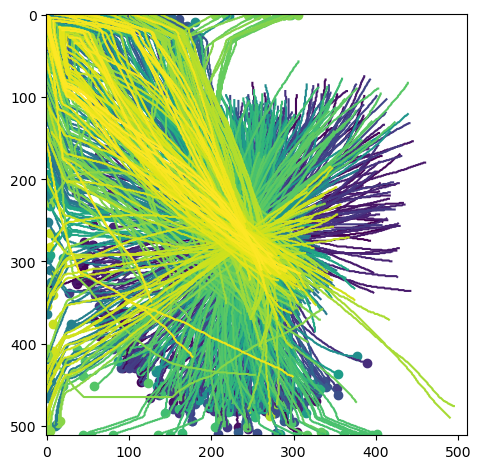

Rendering and collecting frames...


100%|██████████| 715/715 [00:51<00:00, 13.82it/s]


Saving TIFF stack to: D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005\oriented_stack.tif
TIFF stack saved successfully.


<Figure size 640x480 with 0 Axes>

In [4]:
import orient_v2
_ = importlib.reload(sys.modules['orient_v2'])

SPLINE_PTH = MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'spline.json')

# command-line arguments
sys.argv = ["", SPLINE_PTH]

orient_v2.main()

100%|██████████| 715/715 [00:01<00:00, 424.07it/s]


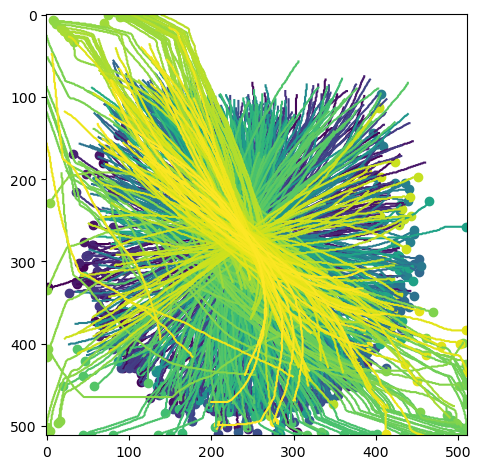

Rendering and collecting frames...


100%|██████████| 715/715 [00:33<00:00, 21.57it/s]


Saving TIFF stack to: D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005\oriented_stack.tif
TIFF stack saved successfully.


<Figure size 640x480 with 0 Axes>

In [8]:
import orient
_ = importlib.reload(sys.modules['orient'])

SPLINE_PTH = MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'spline.json')
nose_y = 210
nose_x = 9

# command-line arguments
sys.argv = ["", SPLINE_PTH, str(nose_y), str(nose_x)]

orient.main()

## 8. WARP

`conda activate g5ht-pipeline`

- ouputs: `warped/*.tif` and `masks/*.tif`

TODO: parallelize

In [9]:
import warp
_ = importlib.reload(sys.modules['warp'])

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

start_index = 0
end_index = num_frames

for i in tqdm(range(start_index, end_index)):
    # command-line arguments
    sys.argv = ["", PTH, i]

    warp.main()

100%|██████████| 715/715 [1:35:53<00:00,  8.05s/it]


## 9. REGISTER

`conda activate g5ht-pipeline`

__ALTERNATIVELY__: register using the wholistic registration algorithm, currently in MATLAB

TODO: parallelize / make faster

- pick a good representative fixed frame that you want to register everything to
  - copy it to the main output folder and name it `fixed_xxxx.tif`
  - copy the corresponding mask and name it `fixed_mask_xxxx.tif`

In [ ]:
import reg
_ = importlib.reload(sys.modules['reg'])

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

start_index = 0
end_index = num_frames
# zoom = 1 # albert was using 3
zoom = 3

for i in tqdm(range(start_index, end_index)):
    # command-line arguments
    sys.argv = ["", PTH, i, str(zoom)]
    reg.main()

  1%|          | 4/715 [07:12<21:09:26, 107.13s/it]

### REGISTER WITH GFP+1 TO RFP

TRIM LAST RFP ZSLICE, TRIM FIRST GFP ZSLICE

seems to be that as of 20251204, all recordings were taken such that the i zslice in red channel corresponds to i+1 zslice in green channel

In [ ]:
import sys
import os
from tqdm import tqdm
import importlib

from reg_gfp_indexing import main as reg_worm

PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_aligned'

for i in tqdm(range(1200)):
    # command-line arguments
    sys.argv = ["", PTH, i, "1"]
    reg_worm()

### MAKE MOVIES OF REGISTERED DATA (see `reg_microfilm.ipynb`)